In [1]:
from graphviz import Digraph
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import networkx as nx


In [3]:
iris = load_iris()
X, y = iris.data, iris.target

print("Data shape:", X.shape)
print("Target shape:", y.shape)
print("Target names:", iris.target_names)
print("\nDataset description:\n", iris.DESCR[:500], "...")


Data shape: (150, 4)
Target shape: (150,)
Target names: ['setosa' 'versicolor' 'virginica']

Dataset description:
 .. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ...


In [4]:
class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        """
        A node in the decision tree.
        - feature_index: index of the feature to split on
        - threshold: threshold value for the split
        - left: left child node
        - right: right child node
        - value: predicted class (only for leaf nodes)
        """
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf(self):
        """Return True if this node is a leaf (no children)."""
        return self.value is not None

class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.root = None

    def fit(self, X, y):
        """Train the decision tree by building it from the training data"""
        self.root = self.build_tree(X, y, depth=0)

    def build_tree(self, X, y, depth):
        num_samples, num_features = X.shape
        unique_labels = np.unique(y)

        # Stopping conditions
        if len(unique_labels) == 1:  # only one class
            return Node(value=unique_labels[0])
        if self.max_depth is not None and depth >= self.max_depth:
            return Node(value=np.bincount(y).argmax())  # majority class

        # Find the best split
        best_gini = 1.0
        best_idx, best_threshold = None, None

        for feature_idx in range(num_features):
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                left_mask = X[:, feature_idx] <= threshold
                right_mask = ~left_mask
                if left_mask.sum() == 0 or right_mask.sum() == 0:
                    continue
                gini = self.gini_impurity(y[left_mask], y[right_mask])
                if gini < best_gini:
                    best_gini = gini
                    best_idx = feature_idx
                    best_threshold = threshold

        # If no split found, return majority class
        if best_idx is None:
            return Node(value=np.bincount(y).argmax())

        # Split the dataset
        left_mask = X[:, best_idx] <= best_threshold
        right_mask = ~left_mask

        left_child = self.build_tree(X[left_mask], y[left_mask], depth + 1)
        right_child = self.build_tree(X[right_mask], y[right_mask], depth + 1)

        return Node(feature_index=best_idx, threshold=best_threshold,
                    left=left_child, right=right_child)

    def gini_impurity(self, y_left, y_right):
        def gini(y):
            probs = [np.sum(y == c) / len(y) for c in np.unique(y)]
            return 1 - sum(p ** 2 for p in probs)

        n = len(y_left) + len(y_right)
        return (len(y_left) / n) * gini(y_left) + (len(y_right) / n) * gini(y_right)

    def predict(self, X):
        return np.array([self._predict(inputs, self.root) for inputs in X])

    def _predict(self, inputs, node):
        if node.value is not None:
            return node.value
        if inputs[node.feature_index] <= node.threshold:
            return self._predict(inputs, node.left)
        else:
            return self._predict(inputs, node.right)


In [5]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize your Decision Tree
my_tree = DecisionTree(max_depth=4)

# Train the tree
my_tree.fit(X_train, y_train)


In [6]:
# Predict and evaluate
y_pred = my_tree.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


Accuracy: 1.0
Confusion Matrix:
 [[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]


In [7]:
import networkx as nx
import matplotlib.pyplot as plt

def add_nodes_edges(node, graph, parent=None):
    """
    Recursively add nodes and edges from your DecisionTree to a networkx graph.
    """
    if node is None:
        return

    # Label the node
    if node.is_leaf():
        label = f"Leaf: {node.value}"
    else:
        label = f"X{node.feature_index} <= {node.threshold:.2f}"

    graph.add_node(label)

    # Connect to parent
    if parent:
        graph.add_edge(parent, label)

    # Recurse for children
    add_nodes_edges(node.left, graph, label)
    add_nodes_edges(node.right, graph, label)

def plot_tree_graph(tree_root):
    """
    Plots the tree using networkx and matplotlib
    """
    G = nx.DiGraph()
    add_nodes_edges(tree_root, G)

    plt.figure(figsize=(12, 8))

    # Use a hierarchical layout
    try:
        from networkx.drawing.nx_agraph import graphviz_layout
        pos = graphviz_layout(G, prog='dot')
    except ImportError:
        pos = nx.spring_layout(G, seed=42)  # fallback

    nx.draw(G, pos, with_labels=True, node_size=2500, node_color='lightblue', font_size=10)
    plt.show()


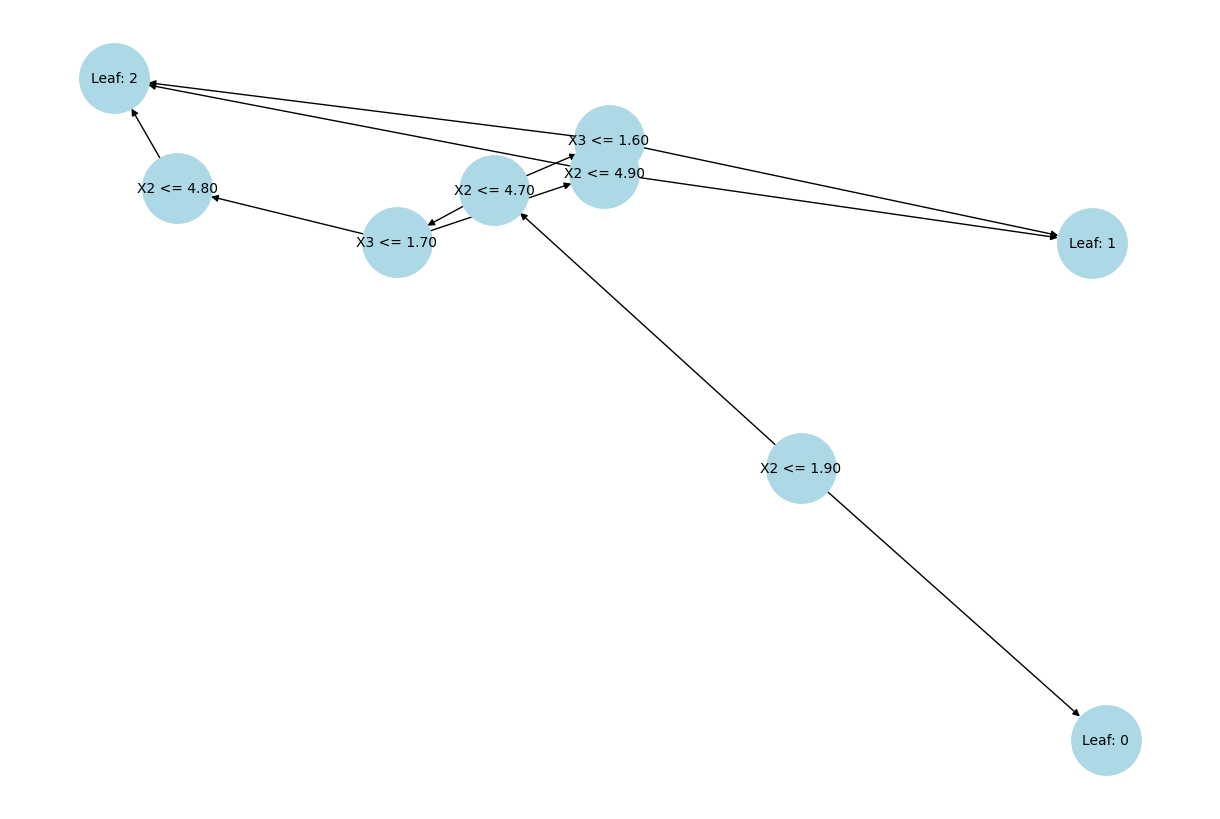

In [8]:
plot_tree_graph(my_tree.root)
